In [898]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, hamming_loss
from skmultilearn.model_selection import iterative_train_test_split
import seaborn as sns
import re
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

In [899]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Exploratory Data Analysis
### Import Data

In [900]:
job_level_data = pd.read_excel("data/JobLevelData.xlsx")
job_level_data

,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure / Chief Information Security Officer",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN
...,...,...,...,...,...
2235,Net Software Architect and Team Project Lead,Manager,NaN,NaN,NaN
2236,Solutions Architect & Technical Lead,Manager,Individual Contributor/Staff,NaN,NaN
2237,"Manager, Salesforcecom Administration and Release Engineering",Manager,NaN,NaN,NaN
2238,Innovation Automation Architect,Manager,NaN,NaN,NaN


### Handling Missing Data

Let's identify rows where all target columns are NaN, meaning no label is assigned to the position title.

Upon analysis, there are 10 rows without labels, representing only 0.4% of the data. Since this is a very small percentage, several actions could be taken to handle these rows:

- **Manual Labeling**. Given the small number of entries, it might be possible to ask the data provider or client to label them manually. However, for now we don't have direct communication with the client and also lack sufficient knowledge of the data's context to label them accurately ourselves.
- **Data Imputation**. There are several possible variants of imputation: 

    -  **Fill with default values, e.g. "Unknown"**. Not good approach, as introducing a new class may confuse the model and reduce the quality of predictions.
    - **Predictive Imputation**. Might be an overkill for this size of data. 

- **Removing the rows with missing data**. Removing NaN rows may be a reasonable solution, as it would likely have little impact on model performance.

In [901]:
nan_rows = job_level_data[job_level_data.drop(columns=['Title']).isna().all(axis=1)]
print(f"Percentage of not labeled data: {len(nan_rows) / len(job_level_data) * 100}")
nan_rows

Percentage of not labeled data: 0.4464285714285714


,Title,Column 1,Column 2,Column 3,Column 4
29,CINO,NaN,NaN,NaN,NaN
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Committee, Member of Remuneration and Nominations Committees",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
829,Release of Information Tech II,NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN
1406,"Global People Systems, Processes and Information Manager",NaN,NaN,NaN,NaN
1713,Supplier Quality Engineer,NaN,NaN,NaN,NaN
1785,RC Environmental and Cyber Specialized Subscription Manager,NaN,NaN,NaN,NaN
2182,Senior Independedirector and Chair of the Customer and Communities Network,NaN,NaN,NaN,NaN


It was decided to remove the rows with missing data.

In [902]:
job_level_data.drop(nan_rows.index, inplace=True)

### Merging Label Columns into a List

To simplify the manipulation of label data and make it suitable for model input, we need to combine the values from multiple columns into a single list.

In [903]:
job_level_data["Label"] = job_level_data.drop(columns=["Title"]).values.tolist()
job_level_data.drop(columns=["Column 1", "Column 2", "Column 3", "Column 4"], inplace=True)

def remove_nans_from_array(list):
    return [label for label in list if not pd.isna(label)]

job_level_data["Label"] = job_level_data["Label"].apply(remove_nans_from_array)
job_level_data["Label"] = job_level_data["Label"].apply(lambda labels: sorted(labels))

job_level_data

,Title,Label
0,Vice President / Director of Systems Engineering,[Vice President]
1,Systems Engineer; Systems Architect,"[Individual Contributor/Staff, Manager]"
2,"Executive Director, Global IT Infrastructure / Chief Information Security Officer","[Chief Officer, Director]"
3,CTO/Executive Director of Technology Services,"[Chief Officer, Director]"
4,"Vice President, CIO",[Vice President]
...,...,...
2235,Net Software Architect and Team Project Lead,[Manager]
2236,Solutions Architect & Technical Lead,"[Individual Contributor/Staff, Manager]"
2237,"Manager, Salesforcecom Administration and Release Engineering",[Manager]
2238,Innovation Automation Architect,[Manager]


### Distribution of Labels

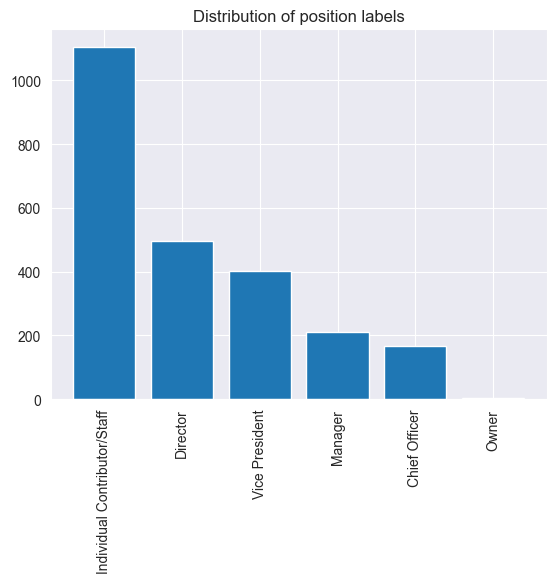

In [904]:
labels_list = [label for labels_list in job_level_data["Label"] for label in labels_list]
labels_count = sorted(Counter(labels_list).items(), key=lambda x: x[1], reverse=True)
labels_count_keys, labels_count_values = zip(*labels_count)

fig, ax = plt.subplots()
ax.bar(labels_count_keys, labels_count_values)
ax.set_title('Distribution of position labels')
plt.xticks(rotation=90) 

plt.show()

It can be observed from the distribution, the data is highly imbalanced, with "Owner" label being highly under respresented. This imbalance requires further attention during model training and evaluation.

### "Owner" Label Exploration

In [905]:
owner_label_entries = job_level_data[job_level_data["Label"].apply(lambda labels: "Owner" in labels)]
owner_label_entries

,Title,Label
22,CoFounder & CTO,"[Chief Officer, Owner]"
119,"Chief Operating Officer, Co-Founder","[Chief Officer, Owner]"
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1933,"Founder, COO","[Chief Officer, Owner]"


As can be observed from the data, there is only 4 entries labeled as "Owner". This is insufficient for effectively training a machine learning model, especially for creating an adequate train-test split.

To address this, we can check if we can assign the "Owner" label based on whether the title contains keywords like "Owner" or "Founder" during the model inference.  

In [906]:
job_level_data[job_level_data["Title"].apply(lambda title: "Owner" in title)]

,Title,Label
30,Owner & Data Architect,"[Chief Officer, Manager]"
896,"Senior Manager Product Owner, Wireless Expansion Network Rollout","[Director, Manager, Vice President]"
998,Co-Owner & Marketing Manager,"[Chief Officer, Manager]"
1054,Practice Owner,[Individual Contributor/Staff]
1222,"Co-Owner, Vice President and General Counsel",[Owner]
1481,In App Learning Owner Software,[Individual Contributor/Staff]
1566,Owner Services Coordinator,[Individual Contributor/Staff]
1632,Owner / Franchisee,[Chief Officer]
1828,Senior Software Consultant / Product Owner,[Individual Contributor/Staff]
1847,"Product Owner Digital, Data and IS Direction",[Manager]


Inspecting data above, it was found that not all titles containing the words "Owner" or "Founder" are labeled as "Owner." This suggests that making a decision to hard-code this category after model training would be unreliable. 

In conclusion, the "Owner" label may not be predictable given the data currently available. As there are usually only a few owners of the company, it would be better to label the data manually on top of models prediction. Therefore, we will remove the entries with the "Owner" label.

In [907]:
job_level_data.drop(owner_label_entries.index, inplace=True)

### Label One-Hot Encoding


In [908]:
mlb = MultiLabelBinarizer()
one_hot_encoded_labels = mlb.fit_transform(job_level_data["Label"])
one_hot_df = pd.DataFrame(one_hot_encoded_labels, columns=mlb.classes_)
job_level_data["Label"] = one_hot_df.values.tolist()

classes_labels = mlb.classes_
print(classes_labels)
job_level_data

['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Vice President']


,Title,Label
0,Vice President / Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer; Systems Architect,"[0, 0, 1, 1, 0]"
2,"Executive Director, Global IT Infrastructure / Chief Information Security Officer","[1, 1, 0, 0, 0]"
3,CTO/Executive Director of Technology Services,"[1, 1, 0, 0, 0]"
4,"Vice President, CIO","[0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2236,Solutions Architect & Technical Lead,"[0, 0, 1, 1, 0]"
2237,"Manager, Salesforcecom Administration and Release Engineering","[0, 0, 0, 1, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


### Correlation Matrix
The following observations can be made from the correlation matrix:
- The correlations are negative or 0, meaning that the labels rarely occur with each other.
- The correlation matrix shows a hierarchy in the company, with lower positions such as "Individual Contributor/Staff" having strong negative correlations with higher positions like "Director" and "Vice President". The model will rather think of them as mutually exclusive.

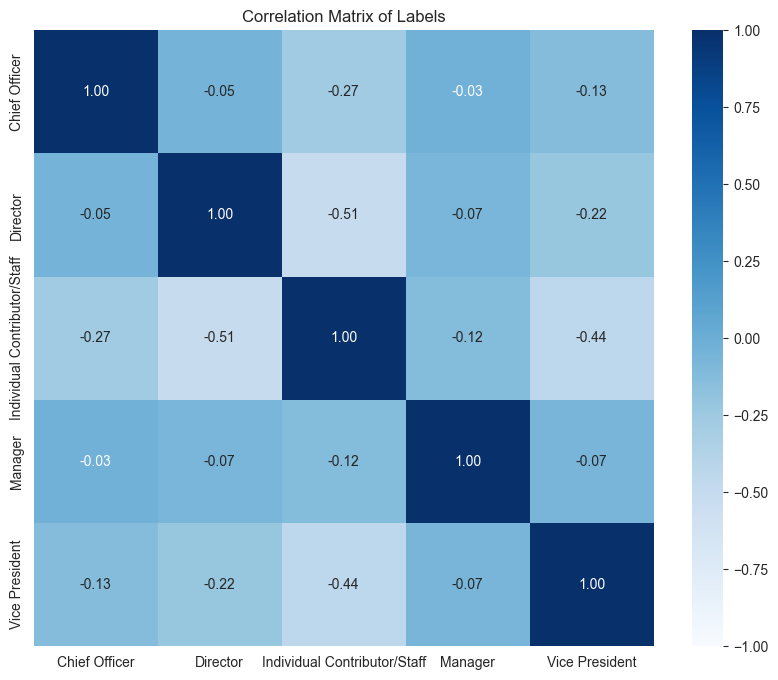

In [909]:
correlation_matrix = one_hot_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Labels')
plt.show()

### Text Preprocessing

In [910]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

job_level_data["Title"] = job_level_data["Title"].apply(preprocess_text)
job_level_data

,Title,Label
0,Vice President Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer Systems Architect,"[0, 0, 1, 1, 0]"
2,Executive Director Global IT Infrastructure Chief Information Security Officer,"[1, 1, 0, 0, 0]"
3,CTO Executive Director of Technology Services,"[1, 1, 0, 0, 0]"
4,Vice President CIO,"[0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2236,Solutions Architect Technical Lead,"[0, 0, 1, 1, 0]"
2237,Manager Salesforcecom Administration and Release Engineering,"[0, 0, 0, 1, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


As BERT tokenizer separates 

We do not perform any other preprocessing steps, such as stemming or lemmatization, as the BERT model is designed to understand textual data in context.

### Tokenization
Cased BERT model will be used to tokenize the data (wordpiece algorithm). The cased model was chosen as the data contains abbreviations which are case-sensitive.

In [911]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [912]:
def split_text(text):
    return tokenizer.tokenize(text)

max_len = job_level_data["Title"].apply(split_text).apply(len).max()
print("Maximum lengths of tokenized sentence: ", max_len)

Maximum lengths of tokenized sentence:  21


## Dataset Loading
Define important constants

In [913]:
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 64
MAX_EPOCHS = 50
EARLY_STOPPING_PAT = 4
THRESHOLD = 0.5

In [914]:
# handle data preprocessing
class JobTitlesDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_len):
        self.titles = titles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len  # maximum length of tokenized sentence

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        encoded_data = self.tokenizer.encode_plus(
            self.titles[item],
            add_special_tokens=True,  # tokens required for BERT
            max_length=self.max_len,
            return_token_type_ids=False,  # no sentence pair task
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # differentiate between padding and data
            return_tensors='pt'
        )
        return {
            'input_ids': encoded_data['input_ids'].flatten(),
            'attention_mask': encoded_data['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

### Train Test Split
Important stratification

In [915]:
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    job_level_data['Label'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Train data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Train data: (1780,)
Test data: (446,)


In [916]:
train_dataset = JobTitlesDataset(
    titles=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = JobTitlesDataset(
    titles=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Model Definition and Training

In [917]:
class JobTitleClassifier(nn.Module):
    def __init__(self, n_classes):
        super(JobTitleClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased') # pre-trained bert model
        self.dropout = torch.nn.Dropout(0.3) # regularization
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes) # classification 
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        output = self.dropout(output.pooler_output)
        output = self.linear(output)
        return output

model_bert_classifier = JobTitleClassifier(len(mlb.classes_)).to(device)

In [918]:
adam_optimizer = torch.optim.AdamW(model_bert_classifier.parameters(), lr=2e-5)
bce_loss = nn.BCEWithLogitsLoss() # includes sigmoid activation
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, mode='min', patience=2, factor=0.2)

In [919]:
def train_classifier(model,
                     data_loader,
                     loss_fn,
                     optimizer,
                     device):
    model = model.train()
    losses = []
    
    for batch_num, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        true_labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, true_labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return np.mean(losses)


In [920]:
def validation(model,
               data_loader,
               loss_fn,
               device):
    
    model = model.eval()
    losses = []
    predictions = []
    targets = []
    
    # ensures no gradients are computed during test mode
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            true_labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            eval_loss = loss_fn(outputs, true_labels).item()
            losses.append(eval_loss)
            
            preds = torch.sigmoid(outputs)
            predictions.extend(preds.cpu().numpy())
            targets.extend(true_labels.cpu().numpy())
            
    return np.mean(losses), predictions, targets

### Training and Evaluation Process
According to [Correlation analysis of performance measures for multi-label classification (2013)](https://www.sciencedirect.com/science/article/abs/pii/S0306457318300165), these are the most widely-used performance measures for multi-label classification:
- **Hamming Loss**: the most recommended due to its lack of correlation with other measures (avoiding redundancy) and being the most employed in literature at the time of paper writing.
- **F1 and Accuracy**: have strong correlation with other metrics, making them representative measures that reduce the need to report multiple similar metrics.



In [921]:
train_losses = []
val_losses = []

hamming_loss_scores = []
f1_scores = []
accuracy_scores = []

all_targets = []
all_predictions = []

best_loss = float('inf')
best_model_weights = None
patience = EARLY_STOPPING_PAT

for epoch in range(MAX_EPOCHS):
    print(f'Epoch {epoch + 1}')

    # Training
    train_loss = train_classifier(model_bert_classifier, train_loader, bce_loss, adam_optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss, predictions, targets = validation(model_bert_classifier, test_loader, bce_loss, device)
    val_losses.append(val_loss)

    # Update learning rate
    plateau_scheduler.step(val_loss)
    print(f"Current learning rate: {adam_optimizer.param_groups[0]['lr']}")

    predictions = np.array(predictions) >= THRESHOLD
    targets = np.array(targets)

    all_targets.extend(targets)
    all_predictions.extend(predictions)

    print(f"Training loss: {train_loss:.5f}, Validation loss: {val_loss:.5f}")

    accuracy = accuracy_score(targets, predictions)
    print(f"Accuracy: {accuracy:.5f}")

    f1 = f1_score(targets, predictions, average='macro', zero_division=1)
    print(f"F1: {f1:.5f}")

    hamming_loss_score = hamming_loss(targets, predictions)
    print(f"Hamming Loss: {hamming_loss_score:.5f}")

    hamming_loss_scores.append(hamming_loss_score)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model_bert_classifier.state_dict())
        patience = EARLY_STOPPING_PAT 
    else:
        patience -= 1
        if patience == 0:
            break

    model_bert_classifier.load_state_dict(best_model_weights)
    print("\n")

Epoch 1
Current learning rate: 2e-05
Training loss: 0.50441, Validation loss: 0.36555
Accuracy: 0.43049
F1: 0.18288
Hamming Loss: 0.13139


Epoch 2
Current learning rate: 2e-05
Training loss: 0.29916, Validation loss: 0.22439
Accuracy: 0.77354
F1: 0.54112
Hamming Loss: 0.06368


Epoch 3
Current learning rate: 2e-05
Training loss: 0.19554, Validation loss: 0.17948
Accuracy: 0.82960
F1: 0.73734
Hamming Loss: 0.05157


Epoch 4
Current learning rate: 2e-05
Training loss: 0.15516, Validation loss: 0.15280
Accuracy: 0.85202
F1: 0.80814
Hamming Loss: 0.04484


Epoch 5
Current learning rate: 2e-05
Training loss: 0.12486, Validation loss: 0.13486
Accuracy: 0.86547
F1: 0.82870
Hamming Loss: 0.04081


Epoch 6
Current learning rate: 2e-05
Training loss: 0.10520, Validation loss: 0.13737
Accuracy: 0.85650
F1: 0.81835
Hamming Loss: 0.04529


Epoch 7
Current learning rate: 2e-05
Training loss: 0.10478, Validation loss: 0.13782
Accuracy: 0.85874
F1: 0.80693
Hamming Loss: 0.04574


Epoch 8
Current lear

## Results Interpretation

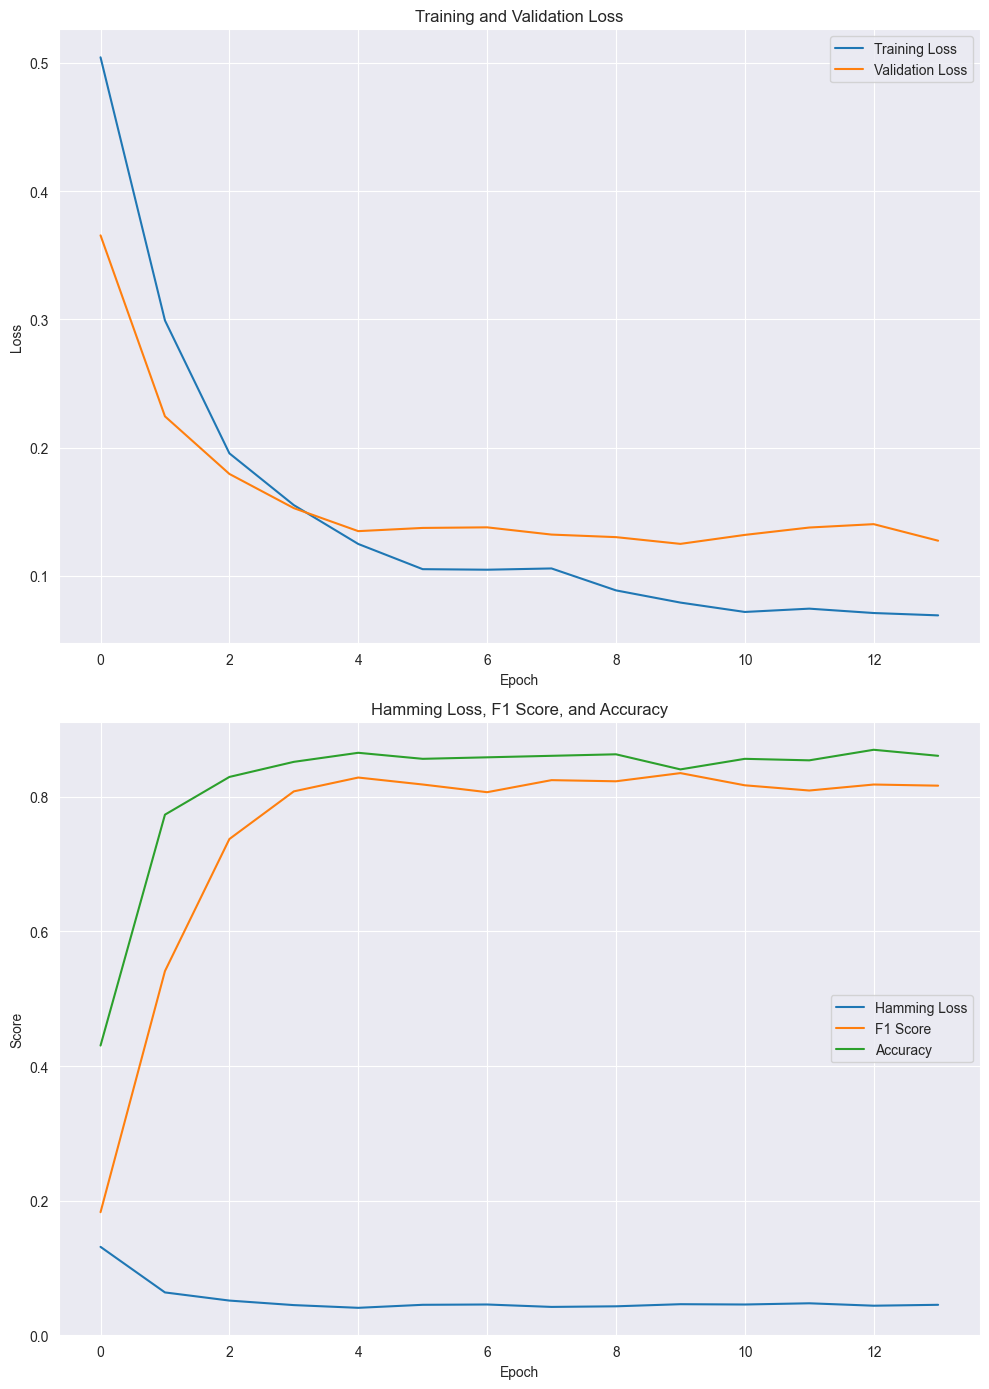

In [922]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(hamming_loss_scores, label='Hamming Loss')
ax2.plot(f1_scores, label='F1 Score')
ax2.plot(accuracy_scores, label='Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_title('Hamming Loss, F1 Score, and Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

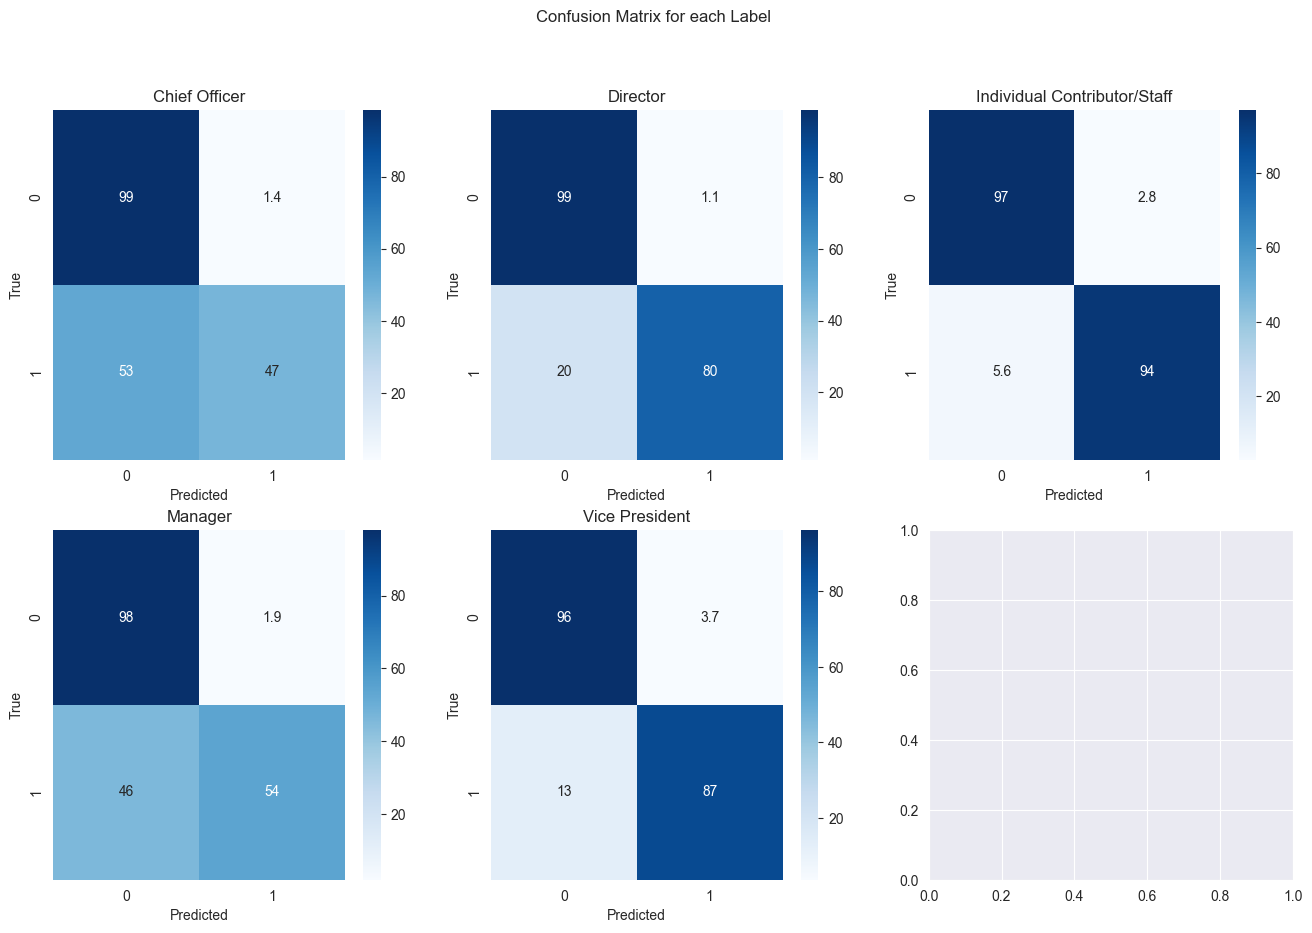

In [923]:
cm = multilabel_confusion_matrix(np.array(all_targets), np.array(all_predictions))

f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.suptitle("Confusion Matrix for each Label")

for i, matrix in enumerate(cm):
    with np.errstate(invalid='ignore'):
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
        normalized_matrix[np.isnan(normalized_matrix)] = 0 
    ax = axes[i//3, i % 3]
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classes_labels[i])

plt.show()